In [1]:
# 1. Text Processing & NLP Libraries
import re
import spacy
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser

# 2. Data Manipulation & Analysis
import pandas as pd
import numpy as np

# 3. Visualization Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 4. Machine Learning & Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF


# Load Data Loading

In [2]:
df = pd.read_csv('first_class_df.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Review,Seat Type
0,22008,22008,Puerto Escondido to Mexico City. Aeromar is ...,First Class
1,22009,22009,I did not make this trip because Aeromexico ...,First Class
2,22010,22010,I had a flight from Cancun to Los Cabo’s with...,First Class
3,22011,22011,Reunion to Chennai. We were really disappoin...,First Class
4,22012,22012,Recently flew Air China in first-class from B...,First Class


# Data Pre-processing

In [3]:
# Get English stopwords
stop_words = set(stopwords.words('english'))  

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')  

# Preprocessing function
def preprocess(doc):
    
    # Remove email addresses
    doc = re.sub(r'\S*@\S*\s?', '', doc)
    
    # Process the document using SpaCy
    spacy_doc = nlp(doc)
    
    # Lemmatize tokens, keep only alphabetic tokens of length >= 3
    lemmatized_tokens = [token.lemma_ for token in spacy_doc if token.is_alpha and len(token) >= 3]
    
    # Convert tokens to lowercase and remove stopwords
    cleaned_tokens = [token.lower() for token in lemmatized_tokens if token.lower() not in stop_words]
    
    return cleaned_tokens

In [4]:
# Apply preprocessing function
df['Processed_comments'] = df['Review'].apply(preprocess)
df.head()

,Unnamed: 0.1,Unnamed: 0,Review,Seat Type,Processed_comments
0,22008,22008,Puerto Escondido to Mexico City. Aeromar is ...,First Class,"[puerto, escondido, mexico, city, aeromar, usu..."
1,22009,22009,I did not make this trip because Aeromexico ...,First Class,"[make, trip, aeromexico, bad, customer, servic..."
2,22010,22010,I had a flight from Cancun to Los Cabo’s with...,First Class,"[flight, cancun, los, cabo, connection, mexico..."
3,22011,22011,Reunion to Chennai. We were really disappoin...,First Class,"[reunion, chennai, really, disappointed, air, ..."
4,22012,22012,Recently flew Air China in first-class from B...,First Class,"[recently, fly, air, china, first, class, beij..."


# N-Grams

In [5]:
# Define the LBMD (Logarithmic Bigram Mutual Dependency) function
def lbmd(worda_count, wordb_count, bigram_count, len_vocab, min_count, corpus_word_count, delta=1):
    # Calculate probabilities
    # Joint probability of A and B co-occurrce (bigram)
    p_xy = bigram_count / corpus_word_count  
    
    # Probability of word A occurring
    p_x = worda_count / corpus_word_count  
    
    # Probability of word B occurring
    p_y = wordb_count / corpus_word_count  
    
    # Return the LBMD score
    return np.log(p_xy + delta) - np.log(p_x * p_y + delta)

#  N-grams (bigrams and trigrams) functions using PMI and LBMD
def make_n_grams(texts, min_count=10, threshold=0.3):
    
    # Detect bigrams using normalized PMI 
    bigram = Phrases(texts, min_count=min_count, threshold=threshold, scoring='npmi')
    bigram_mod = Phraser(bigram) 
    
    # Detect trigrams using LBMD 
    trigram = Phrases(bigram[texts], threshold=50, scoring=lbmd) 
    trigram_mod = Phraser(trigram) 
    
    # Apply the bigram and trigram models to the tokenized texts
    bigrams_text = [bigram_mod[doc] for doc in texts] 
    trigrams_text = [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    
    return trigrams_text  # Return texts containing bigrams and trigrams

# Apply the N-gram fucntion to processed comments
tokens_reviews = make_n_grams(df['Processed_comments'])

# Rejoin the tokenized N-grams into full sentences for Bag of Words
tokens_reviews_joined = [' '.join(doc) for doc in tokens_reviews]

# Feature Etraction

In [6]:
# Initialize CountVectorizer for text vectorization
vectorizer = CountVectorizer(
    analyzer='word',                # Analyze words 
    ngram_range=(1, 3),             # Extract 1-grams, 2-grams, and 3-grams
    min_df=10)                      # Ignore terms that appear in fewer than 10 documents

# Fit the vectorizer to the data and transform the tokenized and joined reviews into a document-term matrix
data_vectorized = vectorizer.fit_transform(tokens_reviews_joined)

In [7]:
# Create a dictionary based on the tokenized reviews
id2word = corpora.Dictionary(tokens_reviews)

# Topic Modeling

In [8]:
def compute_coherence_values(data_vectorized, texts, dictionary, vectorizer, start=2, limit=15, step=1, random_state=42):
    """
    Compute coherence values of three models with different topic numbers.

    Parameters:
    - model_type: NMF
    - data_vectorized: Document-term matrix
    - texts: Tokenized texts after pre-processing
    - dictionary: Gensim dictionary based on the tokenized texts
    - vectorizer: CountVectorizer
    - start: Minimum topic number
    - limit: Maximum topic number 
    - step: Step size for different topic numbers
    - random_state: Random seed for reproducibility

    Returns:
    - coherence_values: A list of coherence values for different numbers of topics
    """
    
    # Initialize an empty list for coherence values
    coherence_values = []
    
    # The range of topic numbers
    topic_numbers = range(start, limit, step)

    for num_topics in topic_numbers:
        # Initialize the respective topic model
        model = NMF(n_components=num_topics, random_state=random_state)

        # Fit the model to the vectorized data and transform the data
        model_output = model.fit_transform(data_vectorized)

        # Extract the top words from each topic
        topics = []
        for topic in model.components_:
            # Get the top 10 words for each topic
            top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            topics.append(top_words)

        # Compute coherence value using Gensim's CoherenceModel
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence) 

    # Return the topic numbers and their corresponding coherence values
    return topic_numbers, coherence_values

In [9]:
# Apply compute_coherence_values function
nmf_topic_numbers, nmf_coherences = compute_coherence_values(data_vectorized, tokens_reviews, id2word, vectorizer, start=6, limit=16)

/Users/lizihe/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


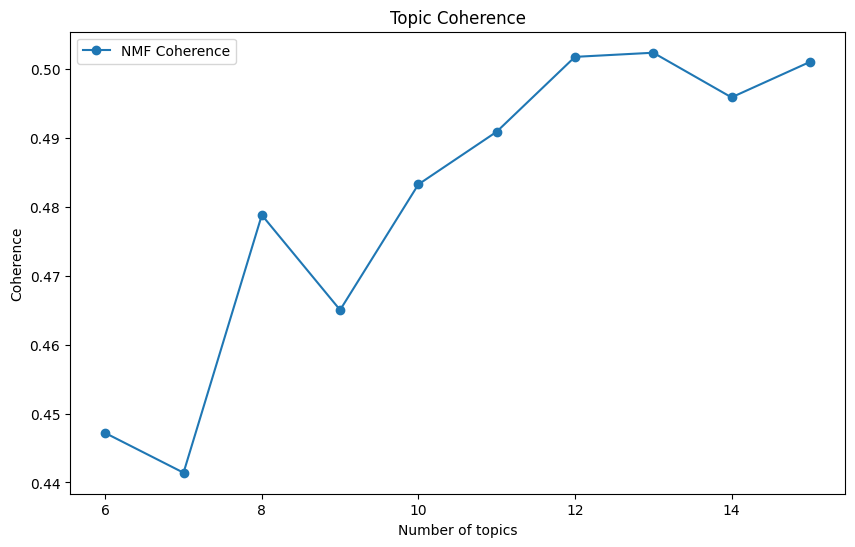

In [10]:
# Visualize the coherence scores of three models
plt.figure(figsize=(10, 6))

plt.plot(nmf_topic_numbers, nmf_coherences, marker='o', label='NMF Coherence')

plt.title('Topic Coherence')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.legend()

plt.show()

In [11]:
print(f"nmf coherences: {nmf_coherences} \n")

nmf coherences: [0.4471752186584072, 0.44140899890227836, 0.4788267428133175, 0.46504143829801425, 0.4832767615815522, 0.4909216620768481, 0.5017942087085244, 0.5023958025146148, 0.4959117061269908, 0.5010519397475102] 



## The Optimal NMF Model Visualization

In [12]:
def extract_topics(model, feature_names, topic_values, num_top_words=10):
    """
    Extract topic information containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"

    Parameters:
    - model: NMF
    - feature_names: List of feature names from CountVectorizer
    - topic_values: Document-term matrix
    - num_top_words: Top 10 keywords

    Returns:
    - topic_df: Data Frame containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"
    """
    
    # List of top words for each topic
    topic_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Index of the top words for the topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        
        # Map the indexs to the features
        top_features = [feature_names[i] for i in top_features_ind]
        topic_words.append(", ".join(top_features))
    
    # Calculate topic proportions
    topic_proportions = np.mean(np.abs(topic_values), axis=0)
    
    # Normalize topic proportions 
    topic_proportions /= topic_proportions.sum()
    
    # Convert proportions to percentages
    topic_proportions *= 100
    
    # Summarize topic information
    topic_data = {
        "Topic ID": [i+1 for i in range(len(model.components_))],  # Topic number
        "Topic Title": [f"Topic {i+1}" for i in range(len(model.components_))],  # Placeholder for topic label
        "Key Words": topic_words,  # List of top words for each topic
        "Topic Share (%)": [f"{prop:.2f}%" for prop in topic_proportions]  # Topic proportions as percentages
    }

    topic_df = pd.DataFrame(topic_data)
    
    return topic_df  


In [13]:
# Initialize the optimal NMF model with 10 components
optimal_nmf_model = NMF(n_components=13, random_state=42)
# Document-topic matrix (W)  
W = optimal_nmf_model.fit_transform(data_vectorized)
# Topic-word matrix (H)
H = optimal_nmf_model.components_

# Apply extract_topics function to the NMF
topics_df_nmf = extract_topics(optimal_nmf_model, vectorizer.get_feature_names_out(), W)

# Save to a CSV file
topics_df_nmf.to_csv(f'first_class_topics.csv', index=True)
topics_df_nmf

,Topic ID,Topic Title,Key Words,Topic Share (%)
0,1,Topic 1,"service, lounge, crew, food, return, experienc...",5.80%
1,2,Topic 2,"flight, airline, hour, airport, delay, time, f...",15.75%
2,3,Topic 3,"seat, one, child, plane, row, cabin, move, cou...",10.52%
3,4,Topic 4,"first_class, food, passenger, use, airline, me...",8.65%
4,5,Topic 5,"first, service, food, comfortable, seat, go, e...",5.66%
5,6,Topic 6,"first, british_airways, order, cabin_crew, giv...",4.01%
6,7,Topic 7,"well, first, nice, one, crew, offer, get, busi...",9.06%
7,8,Topic 8,"cabin_crew, garuda, take, check, provide, garu...",6.23%
8,9,Topic 9,"could, wife, call, ticket, try, help, say, mak...",5.58%
9,10,Topic 10,"plane, toilet, issue, get, back, outbound, run...",5.32%
